---
>「言葉は賢者の計算手段だ。賢者は言葉で考えるが、愚者は言葉で金もうけをする」 \
> トーマス・ホッブズ(Thomas Hobbes)
---

# CLIP(Contrastive Language-Image Pretraining)



CLIP（Contrastive Language-Image Pretraining）は、OpenAIによって開発された、画像とテキスト（言語）を共同で処理するための機械学習モデル

- テキストの説明とその対応する画像をよく理解するように設計されています。CLIPは言語と画像の両方で働くことができ、そのためには言語モデルと画像認識モデルの両方の特性を備えています。

- 幅広いタスクでゼロショット転移(タスクごとのFine-tuningを必要としない)可能な事前学習画像分類モデルである


## そもそもCLIPとは

CNNなどを学んだが、画像分類を既に1から作成することは、特に制約がない限り、精度を求めるのであれば実際の場面では既に行われなくなりつつある

CLIPの特徴は次のとおりである

- カテゴリーを利用者側で自由に設定できる自然言語教師型画像分類モデル  
データセットとして、一般的な画像と自由度が低いラベルの組み合わせで構成されておらず、画像と自由度が高い画像を説明したテキストを用いているため、ラベルに設定できるカテゴリーが限定されずカテゴリー設定の自由度が向上している

- 巨大な自然言語教師データであるWebImageTextを利用  
インターネットを利用して構築された4億組の画像と画像を説明する自由テキストのペアのデータセットを利用

- 多様なタスクに対するゼロショット転移で転用可能  
多様なタスクに対してゼロショット転移(Zero-Shot Transfer)、つまり、タスク特有のデータセットで学習をしないで事前学習データで学習したモデルを直接タスクに転用することができ、高い精度を達成できる

自然言語表現から直接学習することで、普通のラベルセットよりも拡張性が高くなり、単に学習するだけではなく、ゼロショット転移を可能にする言語表現同士の関連性も獲得することができる

## CLIPの動作原理

### データの前処理

CLIPは大量のテキストと画像データで訓練されており、テキストと画像はペアとして与えられ、各テキスト用と画像用のモデルの両方共に全てのデータを処理する

- テキストエンコーダについて、通常Transformerと呼ばれるモデルで処理さ、GPT（Generative Pretrained Transformer）やBERT（Bidirectional Encoder Representations from Transformers）と同様である

- 画像エンコーダは、通常: 画像は通常CNN（Convolutional Neural Networks）によって処理され、これはResNetやVGGなどの画像認識モデルと同様であるが、Vision Transformerを用いる例も存在する

CLIPの特徴ベクトルは、画像とテキストのそれぞれから生成され、マッチングがとられている

そのロスには、コントラスティブロス(Contrastive Loss)が用いられ、特徴ベクトルがテキストと画像が「一致」するように訓練される

- 正しいテキストと画像のペアの特徴ベクトルが近くなるように、一方で誤ったペアは遠くなるように学習する


# Contrastive Loss

Contrustive Lossは、SimCLR(A Simple Framework for Contrastive Learning of Visual Representations)やMoCo(Momentum Contrust)などで成功を収めた実績のある、対照学習(Contrastive Learning)による表現学習手法で利用される

まず、がContrastive Lossの目的は、**ネガティブなサンプル、つまり異なるサンプル同士については、その結果としての類似度を小さくすること**である

結論から言えば、Hard Contrastive Lossを利用することが重要であり、その理由について説明する


## Constrastive Lossの表現

まず、Hard Contrastive Lossの前に、一般的なContrastive Lossについて説明する

一般的なContrastive Lossは次の式で与えられる

$$L(x_i) = -log\frac{e^{s_{i,i}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

ここで、$s_{i, j} = f(x_i)^Tg(s_j)$は類似度を示し、$f(\cdot)$は画像を超球面にマッピングする特徴量抽出器、$g(\cdot)$は$f$同様、memory bankやmomentum queueなどの何かしらの関数を、$\tau$は温度パラメータを表す

この時、$x_i$が$x_j$として認識される(ポジティブなサンプル同士と扱われる)確率$P_{i,j}$は、次のように定義される

$$P_{i,j} = \frac{e^{s_{i,j}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

つまり、Contrastive lossは、ポジティブなサンプル同士(例えば同一の画像に異なる変換処理を行った場合)の表現は近傍に、ネガティブなサンプル同士(元となる画像が異なる場合)の表現は分離することを目的としている
- ポジティブなサンプル同士の表現の類似度$s_{i,j}(j = i)$は大きく、ネガティブなサンプル同士の表現の類似度$s_{i,j}(j \neq i)$は小さくすることを目的としている



## 勾配について

正のサンプルと負のサンプルの勾配について、

正のサンプル同士の類似度の勾配と、負のサンプル同士の類似度の勾配は次の式で与えられる


$$\frac{\partial L(x_i)}{\partial s(i,i)} = -\frac{1}{\tau}\sum_{k \neq i} P_{i,k}$$
$$\frac{\partial L(x_i)}{\partial s(i,i)} = -\frac{1}{\tau}P_{i,k}$$

これらの式から、以下のことがわかる

- 負のサンプルの勾配は$e^{s(i,j)/\tau}$に比例し、類似度$s(i,j)$と温度$\tau$の値に応じて勾配の大きさが変化する

- 正のサンプルの勾配の大きさは、すべての負のサンプルの勾配の合計と等しくなる$\sum_{k\neq i}|\frac{\partial L(x_i)}{\partial s(i,k)}|/|\frac{\partial L(s_i)}{\partial s(i,i)}| = 1$


## 温度$\tau$について

温度$\tau$は、表現の類似度が高い($s(i,k) (k \neq i)$が大きい負のサンプルに対するペナルティの強さ(勾配の大きさ)を制御する役割を果たす

### $\tau$による影響

まず、ネガティブなサンプル$x_j$に対する相対的なペナルティを表す$r_i(s_{i,j})$は次のように表現される

$$r_i(s_{i,j}) = |\frac{\partial L(x_i)}{\partial s(i,j)}||\frac{\partial L(x_i)}{\partial s(i,i)}|$$

実際に計算すると、以下の式を得る

$$r_i(s_{i,j}) = \frac{e^{s_{i,j}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}}, i \neq j$$

この式において$\tau$を変化させながら$r_s$と$s_i$の関係を調べるとわかるが、温度$\tau$が小さいほど類似度が高いペアに対するペナルティが大きくなり、温度が大きいとペナルティの分布は一様となる

つまり、温度$\tau$が小さいほど、表現の類似度が高い($k \neq i$である場合で$s_{i,k}$が大きい)ネガティブなサンプルが、その他のネガティブなサンプルと比べて重視される(損失関数に強く影響する)ようになる

例えば、温度$\tau$に関する2つの特殊な場合、$\tau \rightarrow 0^+$および$\tau \rightarrow +\infty$について考察する

まず、$\tau \rightarrow 0^+$の場合、損失関数は以下のように近似できる

$$\lim_{\tau \rightarrow 0^+}L(x_i) = \lim_{\tau \rightarrow 0^+}-log\frac{e^{s_{i,i}/\tau}}{\sum_{k \neq i}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}\\
= \lim_{\tau \rightarrow 0^+}\frac{1}{\tau}max[s_{max}-s_{i,i}, 0]$$

この計算が示すように、$\tau$が限りなく0に近い極端な場合では、最も類似度が高いネガティブなサンプルだけが損失関数に影響するように設計されている

逆に$\tau \rightarrow +\infty$の場合は、同様に、

$$\lim_{\tau \rightarrow =\infty}-\frac{N-1}{N\tau}s_{i.i}+\frac{1}{N\tau}\sum^{k \neq i}s_{i,k} + \log{N}$$

となり、$\tau$が限りなく大きい極端な場合では、すべてのネガティブなサンプルの類似度は、大きさによってペナルティをかけられることなく損失関数に影響することがわかる


### $\tau$の本質

ネガティブなサンプルの表現の類似度を小さくすることがContrastive Lossの目的であることは述べた

したがって、$x_i, x_k$の表現の類似度$s_{i,k} (k\neq i)$が大きいとき、これらはモデルが識別に失敗している困難サンプル(ハードサンプル)であるといえる

このような困難なサンプルに対してペナルティをかけて、より損失関数に大きな影響をもたらすように設計されている

言い方を変えれば、Contrastive Lossは、Hardness-aware Lossといえる

その点において、$\tau$はContrastive LossのHardness-aware特性を制御するという重要な役割を果たしていると言える
- 実際、$\tau \rightarrow 0^+$および$\tau \rightarrow +\infty$といった極端な場合で学習を行うと、モデルは有益な情報を学ぶことができず、性能が大きく低下する
- $\tau$を適切に定めることが重要である

## Hard Contrastive Lossについて

類似度が高い困難なサンプルを重視するHardness-aware特性は、Contrastive Lossにおける重要な特性である

この特性をより直接的に実現する方法がHard Constrastive Lossである
- つまり、$s_{i,k}$が一定の閾値$s_\alpha^{(i)}$以上であるサンプルだけを考慮するようにすると、対応するハードコントラスト損失は

$$L_{hard}(x_i) = -log\frac{e^{s_{i,i}/\tau}}{\sum_{s_{i,k} \geq s_\alpha^{(i)}}e^{s_{i,k}/\tau}+e^{s_{i,i}/\tau}}$$

となる

この時の相対的ペナルティ$r_i$は、次のように求まる

$$r_i(s_{i,l}) = \frac{e^{s_{i,l}/\tau}}{\sum_{s_{i,k} \geq s_\alpha^{(i)}}e^{s_{i,k}/\tau}}, i \neq l$$

このHard Contrastive Lossは、上位$K$個のネガティブなサンプルのみを選択することで明示的にHardness-aware特性を付加する方法と、$\tau$により制御するHardness-aware特性による暗黙的な方法の両方を用いて、困難なサンプルへのペナルティ付けを行うことができる

## 埋め込み分布の一様性(Univormity)について

CLIPでは、画像とテキストを共通の埋め込みベクトル（embedding）にマッピングすることが重要である
- 共通の埋め込み空間では、関係するテキストと画像のペアが互いに近い位置にマッピングされるように設計されている

この埋め込み分布には、次の特性がある

- 埋め込みベクトルは画像やテキストの複雑な特性を捉えるため、高次元の空間として表現される
- 微妙な違いや類似性も表現できるように埋め込み空間は連続的である
- 意味的に関連するサンプルが互いに近い位置に配置され、これはContrastive Lossよって強化されている

この埋め込み分布について、その一様性(Uniformity)は、重要な特性であることが知られている

これに基づき、次の式で定義される一様性指標を用いることで調査できる

$$L_{uniformity}(f;t) = \log E_{(x,y)～P_{data}}e^{-t||f(x)-f(y)||^2_2}$$

実際の値は、論文を参照するとよいが、この値は、温度$\tau$が大きくなると、通常のContrastive Lossでは埋め込み分布の一様性が低くなるような値をとり、Hard Contrastive Lossの場合は、全体的にほぼ一定の値をとることが示されている

つまり、総じて一様性の向上に役立っていることがわかる


## 類似サンプルへの許容性(tolerance)について

同一の画像を変換して生成したサンプル同士をポジティブ、異なる画像から得られたサンプル同士をネガティブとするため、実際には類似している(潜在的には正である)サンプル同士の表現が分離されてしまうリスクがある

この問題への許容性(類似するネガティブなサンプル同士の表現を分離しない能力)を定量的に評価するため、同じクラスに属するサンプルの平均類似度をもとに、類似サンプルへの許容性の指標を次のように定める

$$T = E_{x,y～P_{data}}[f(x)^Tf(y))\cdot I_{l(x)=l(y)}]$$

ここで、$I_{l(x)=l(y)}]$は$l(x)=l(y)$のとき$1$、$l(x) \neq l(y)$のとき0となる

この指標についての通常のContrastive LossおよびHard Contrastive Lossの詳細は論文を参照するとよいが、Hard Contrastive Lossは全体として指標の数値が低下していることがわかる

しかしながら、これは一様性の増加の裏返しであり、特に温度が相対的に高い場合、一様性の低下を抑えつつ、類似サンプルへの許容性を高められる可能性がある

通常のContrastive lossにおいては、UniformityとToleranceはトレードオフの関係にある

このトレードオフの関係を回避するため、Hard Contrastive Lossは重要であり、総じて、Contrastive Lossの成功にはHardness-aware特性が重要である
- 一般にHard Contrastive Lossを導入することで性能が向上するといえる

## CLIPのモデル

CLIPに入力されるのは、画像とその内容を説明するテキストのペアがN個セットになったバッチである

この、N個のペアのバッチを与え、バッチ全体でNxN個の可能性のあるペアリングのうち、どのペアリングが実際に発生したかを予測するように訓練される

Image Encoderは、N個の画像からその特徴を表すベクトル I_1〜I_Nを、TextEncoderは、N個のテキストからその特徴を表すベクトル T_1〜T_N をとりだし、内積を計算する

2つのベクトルの内積値が大きいほど類似度が高いため、ペアであるベクトルの掛け算、I_1・T_1, I_2・T_2, I_3・T_3 , ... , I_N・T_N の値を最大化し、ペアではないベクトルの掛け算の値を最小化するように、Image EncoderとText Encoderのパラメータを学習する

- 標準的な画像モデルは画像特徴抽出器と線形分類器を共同で学習してラベルを予測するように学習する

- CLIPは画像エンコーダーとテキストエンコーダーを一緒に訓練し、バッチ内のN個の実ペアの画像とテキストのエンベッディングのコサイン類似度を最大化する一方で、不正確なペアのエンベッディングのコサイン類似度を最小化することで、画像とテキストのバッチ学習例の正しいペアリングを予測するように学習させる、つまり、マルチモーダルエンベッディング空間を学習する

CLIPは、この事前学習によって、画像からもテキストからも、その特徴を適切に表すベクトルを取得できるようになる

テスト時には、学習されたテキストエンコーダは、ターゲットデータセットのクラスの名前や説明を埋め込むことで、ゼロショットの線形分類器を合成することができる

<img src="https://class.west.sd.keio.ac.jp/dataai/text/CLIP1.jpg" width="800">

# CLIPの用途

CLIPは多くの用途で活用されている

- 画像分類  
  通常の画像分類タスクで高い性能を発揮する
- 物体検出  
  複数の物体とそのラベルを同時に認識できる
- ゼロショット学習  
  モデルにとって初見であるタスクやカテゴリに対応する
- 多言語対応  
  テキスト部分が言語モデルであるため、多言語のテキストと画像のペアも理解できる

このように、CLIPは多様なタスクに応用可能であり、画像と言語の複合的な理解が必要な場面で高い性能を発揮する

# CLIPを用いたゼロショット画像分類

8枚のサンプル画像を用いてゼロショット画像分類を実際に行う


## セットアップ

In [1]:
# 1.pytorchバージョン変更
#! pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html #ftfy regex

# GithubからCLIPをクローニング
! git clone https://github.com/openai/CLIP.git
%cd CLIP/clip

# 3.CLIPモデルの重みをダウンロード
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}
! wget {MODELS["ViT-B/32"]} -O model.pt

# simple_tokenizer インストール
! pip install ftfy regex
from simple_tokenizer import *
tokenizer = SimpleTokenizer()

# サンプル画像ダウンロード
! pip install --upgrade gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1vcxH6JOtwh_-FoZ8SNXYlHF9qCi3YoDH', 'food_101.zip', quiet=False)
! unzip food_101.zip

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 21.47 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/CLIP/clip
--2026-01-15 19:41:33--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.253.69, 13.107.226.69, 2620:1ec:29:1::69, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.253.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M   141MB/s    in 2.4s    

2026-01-15 19:41:36 (141 MB/s) - ‘model.pt’ saved [353976522/353976522]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Attemptin

Downloading...
From: https://drive.google.com/uc?id=1vcxH6JOtwh_-FoZ8SNXYlHF9qCi3YoDH
To: /content/CLIP/clip/food_101.zip
100%|██████████| 485k/485k [00:00<00:00, 24.7MB/s]

Archive:  food_101.zip
  inflating: food_101/2847583.jpg    
  inflating: food_101/3415542.jpg    
  inflating: food_101/3428323.jpg    
  inflating: food_101/3483572.jpg    
  inflating: food_101/3574192.jpg    
  inflating: food_101/3627762.jpg    
  inflating: food_101/3666829.jpg    
  inflating: food_101/598436.jpg     


必要となるライブラリを導入

In [2]:
import numpy as np
import torch

## 学習済みモデルをダウンロードして導入

In [3]:
model = torch.jit.load("model.pt").cuda().eval()
model

RecursiveScriptModule(
  original_name=Multimodal
  (visual): RecursiveScriptModule(
    original_name=VisualTransformer
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (ln_pre): RecursiveScriptModule(original_name=LayerNorm)
    (transformer): RecursiveScriptModule(
      original_name=Transformer
      (resblocks): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=ResidualAttentionBlock
          (attn): RecursiveScriptModule(
            original_name=MultiheadAttention
            (out_proj): RecursiveScriptModule(original_name=_LinearWithBias)
          )
          (ln_1): RecursiveScriptModule(original_name=LayerNorm)
          (mlp): RecursiveScriptModule(
            original_name=Sequential
            (c_fc): RecursiveScriptModule(original_name=Linear)
            (gelu): RecursiveScriptModule(original_name=QuickGELU)
            (c_proj): RecursiveScriptModule(original_name=Linear)
          )
   

CLIPモデルについて概要を確認する
- CLIPモデルのパラメータ数は1億5千万
- CLIPモデルへ入力する画像サイズは224×224（RGB）
- CLIPモデルへ入力するテキストは77トークンまでで構成
- CLIPモデルと連携して利用する辞書は、語彙数が49408個

In [4]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## simple_tokenizer の動作を確認

テキストをトークンへ変換してみる

この場合、5文字がそれぞれ5つの数字(トークン)に変換される

In [5]:
index = tokenizer.encode('I learn machine learning system')
print(index)

[328, 1768, 4169, 2378, 2422]


一方で、次のような場合、2文字に対してトークンが3つ消費されている

In [6]:
index = tokenizer.encode('image segmentation')
print(index)

[2867, 10551, 9512]


これは、simple_tokenizeが、BPE(Byte Pair Encoding)と呼ばれる単語を要素に分割して変換する方法を採用しているためである

要素の組み合わせで様々な単語が表現可能になることから、語彙数を少なくすることができる
- segmentation が seg と mentation の2つの要素に分けてトークン化されている

## 動作確認に利用するサンプルデータセットについて

像分類に使用するサンプル画像は、オープンデータセットFood-101から選んだ8枚で、サイズは全て512×512である
- Food-101は、101種類の料理のカラー写真を集めたデータセットで、全部で101,000枚の画像が含まれている

ここでは、「ハンバーガー」、「寿司」、「たこ焼き」、「餃子」、「ラーメン」、「ピザ」、「スパゲッティ」、「オムレツ」を選択した

## 画像の前処理

- preprocessにより、は画像をリサイズして入力可能な224×224サイズに変更
- image_meanにより、画像の輝度平均を整える
- image_stdにより、は画像の輝度バラツキを整える

以上の処理をサンプル画像に施す

In [7]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import glob

# 設定
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# 前処理
images =[]
files = glob.glob('./food_101/*.jpg')
files.sort()
for file in files:
      image = preprocess(Image.open(file).convert("RGB"))
      images.append(image)

image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

print('image_input.shape = ', image_input.shape)

image_input.shape =  torch.Size([8, 3, 224, 224])


## テキストの前処理

今回設定する分類ラベルは、['takoyaki', 'susi', 'spagetti', 'ramen', 'pizza', 'omelette', 'humburger', 'gyoza'] 　の8つ

CLIPは、画像とテキストをペアで学習している関係上、単語だけでは上手く動作しない

そこで、あえて、「This is a photo of a ＊＊＊」という文にして判断させる
- 文頭に<|startoftext|>、文末に<|endoftext|>を加えて、辞書でトークンに変換する
- トークンが77個より少ない場合は余った部分をゼロ埋めし(padding)、トークンが77個を超える場合は切り捨てる


In [8]:
# 分類ラベルの設定
labels = ['takoyaki', 'susi', 'spagetti', 'ramen', 'pizza', 'omelette', 'humburger', 'gyoza']

# ラベルを文の形のトークンへ変換
text_descriptions = [f"This is a photo of a {label}" for label in labels]
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

# トークンをテンソルに変換
for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

中身を確認すると、ゼロ埋めされているのがわかる

text_inputの正しい型は(8,77)であるが、これは先に示した通り、CLIPに入力されるのは、画像とその内容を説明するテキストのペアがN個セットになったバッチである

ここで用いる学習済みモデルでは8個の入力をペアとしてる(N=8)であるため、無理やり8個とも同じ文章にして入力している



In [9]:
# 各データの先頭を表示
print(text_descriptions[0])
print(text_tokens[0])
print(text_input[0])
print(text_input.shape)

This is a photo of a takoyaki
[49406, 589, 533, 320, 1125, 539, 320, 648, 1313, 44677, 49407]
tensor([49406,   589,   533,   320,  1125,   539,   320,   648,  1313, 44677,
        49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0')
torch.Size([8, 77])


## 画像とテキストのcos類似度を計算

実際にCLIPで画像の特徴ベクトルとテキストの特徴ベクトルを抽出し、COS類似度を計算する

CLIPが出力する画像の特徴ベクトル(image_features)、テキストの特徴ベクトル(text_features)とも、512次元のベクトルであり、それが8つまとまっているため、型は(8,512)となる

- model.encode_image(image_input) で、image_input からimage_features（画像の特徴ベクトル）を取り出す

- model.encode_text(text_input) で、text_input から text_features（テキストの特徴ベクトル）を取り出す

- image_features と text_features の内積の結果を100倍し、softmaxで各要素を合計1となる確率分布に変換、そのトップ5を算出

まずは、COS類似度の計算結果を確認する


In [10]:
# CLIPモデルで画像とテキストの特徴を抽出
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 画像の特徴とテキストの特徴からCOS類似度を計算
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

print(image_features.shape)
print(text_features.shape)

torch.Size([8, 512])
torch.Size([8, 512])


cos類似度の計算結果text_probsは、以下のように(8, 8)のテンソルであり、画像がN枚、ラベルがK個あった場合は、(N, K)のテンソルとなる

- 行が画像、列がラベルを表し、該当画像の何列目の値が一番高い値かを見れば、この場合では分類したラベルが推定できる

In [11]:
# COS類似度の計算結果をそのまま表示
print(text_probs)

tensor([[3.7313e-34, 1.0000e+00, 2.9912e-39, 2.7519e-25, 4.3362e-40, 3.3245e-34,
         1.3177e-40, 1.2782e-23],
        [1.0000e+00, 4.0299e-35, 3.4654e-38, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.2253e-34],
        [1.2899e-10, 1.5230e-28, 0.0000e+00, 2.6064e-43, 0.0000e+00, 1.4013e-45,
         0.0000e+00, 1.0000e+00],
        [1.9657e-27, 6.3184e-30, 1.8655e-41, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 8.3725e-37],
        [0.0000e+00, 5.9947e-33, 1.1338e-40, 0.0000e+00, 1.0000e+00, 9.7126e-29,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 5.9577e-29, 1.0000e+00, 1.5733e-34, 4.5597e-37, 1.2892e-43,
         0.0000e+00, 0.0000e+00],
        [6.2636e-23, 6.2317e-31, 1.1070e-43, 0.0000e+00, 5.9274e-27, 1.0000e+00,
         6.7491e-37, 9.2206e-12],
        [0.0000e+00, 2.3648e-22, 0.0000e+00, 5.6052e-45, 2.9698e-41, 8.8282e-44,
         1.0000e+00, 0.0000e+00]], device='cuda:0')


## 予測結果の表示

各画像の右に、COS類似度の値が高かったラベルTOP5とその度合いを表示する

問題なく推定できていることがわかる

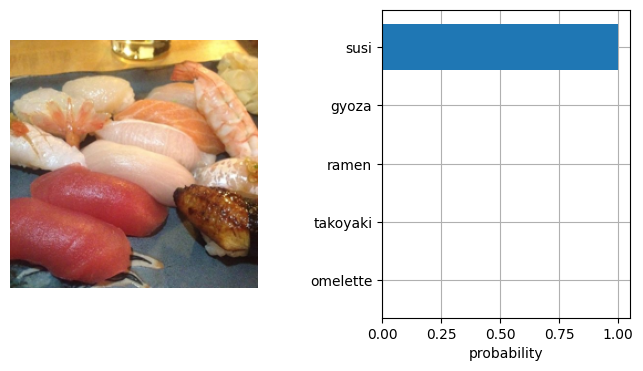

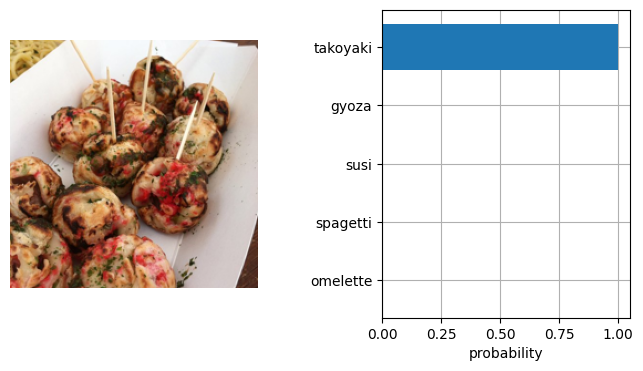

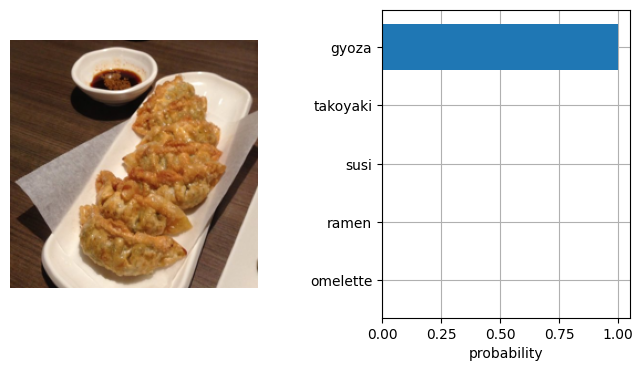

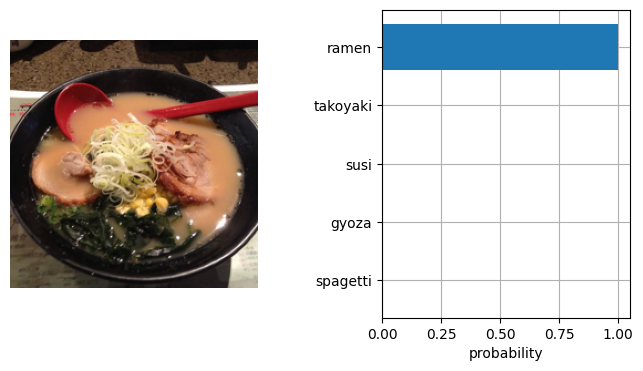

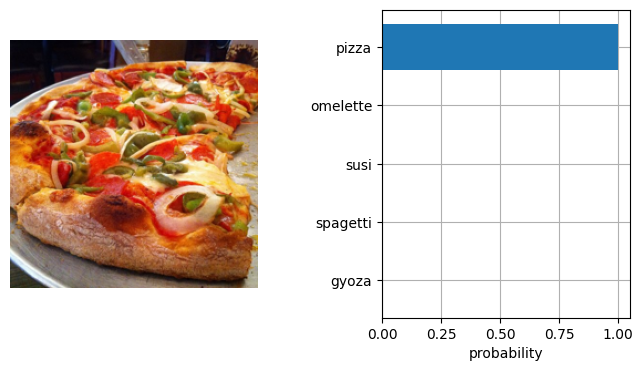

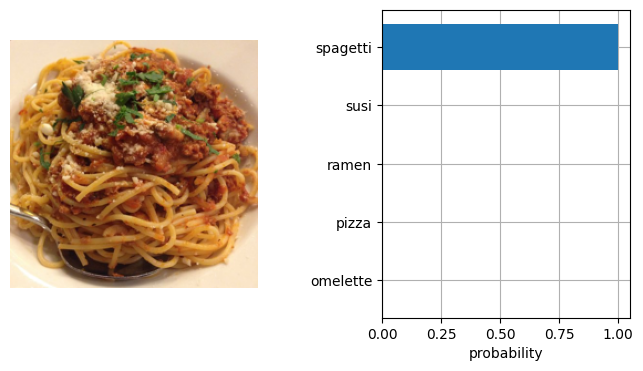

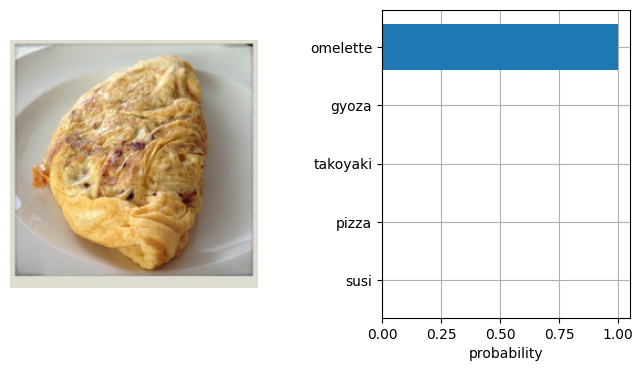

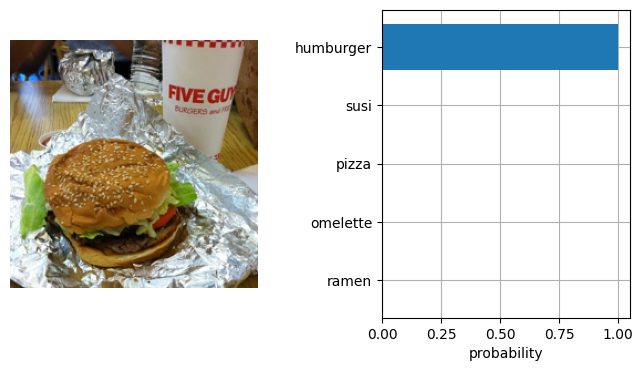

In [12]:
import matplotlib.pyplot as plt

def pred_disp(i, image):
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 2, 1)
      plt.imshow(image.permute(1, 2, 0))
      plt.axis("off")

      plt.subplot(1, 2, 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs[i])
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [labels[index] for index in top_labels[i].numpy()])
      plt.xlabel("probability")

      plt.subplots_adjust(wspace=0.5)
      plt.show()

for i, image in enumerate(images):
     pred_disp(i, image)

# CLIPの応用事例

とにかく、CLIPは大量の応用事例がある

- 画像分類: 通常の画像分類タスク、特に限られたラベルのデータしかない場合やゼロショット学習が必要なケースで有用

- 物体検出: テキストクエリに基づいて画像内の特定の物体を識別やローカライズ

- 画像生成: テキストの指示に基づいて画像を生成する

- 画像キャプション: CLIPを逆に使って、画像からテキスト（キャプション）を生成、医療画像解析などを含めた応用が可能

- コンテンツ推薦: ユーザーが指定したテキストクエリに適した画像やビデオをレコメンド

- 検索エンジン: 画像に基づいて関連するテキストを見つけたり、テキストに基づいて関連する画像を探す

- 自動翻訳: 画像とその説明文が多言語で提供されている場合、CLIPで翻訳タスクを補助

- アートとクリエイティビティ: 作成したアート作品に適切なタイトルや説明を生成

- 監視とセキュリティ: 監視カメラの映像と、特定の事件やアクションを説明するテキストをマッピング

- ユーザーインターフェース: ユーザーが自然言語でクエリを入力し、それに最も適したアイコンやUI要素を提示するようなインターフェース

- 教育: 教材や教育的な内容を画像とともに説明する際に、CLIPを用いることで効果的な学習を提供

- Eコマース: 商品の画像と説明を照合して、顧客に更に適切な商品を推薦

などなど、産業や研究領域で新しい応用例を生まれている


## ALIEN

ALIGN(A Large-scale ImaGe and Noisy-text embedding)は、大量の画像とノイズの多いテキストデータを使った対照学習（Contrastive Learning）を行っており、CLIPと非常に似ていますが、CLIPが先に発表され、ALIGNはその後続である

ALIGNとCLIPの主な違いは次の通り

- CLIPが4億であるのに対して、ALIGNは10億を超えるノイズの多いalt-text(画像のalt属性のテキスト)を使った対照学習である

- CLIPはWikipediaの頻出単語をクエリとしてクロールするというトップダウンアプローチであるが、ALIGNは、画像のalt-textというノイズの多いデータを、高価なフィルタリングなしで使ったボトムアップアプローチである

ノイズの多いデータセットでもCLIPの手法が有効であることを示した貢献は大きい


## BigSleep

かつて、BigGANはStyleGANと双璧をなす強力なモデルであったが、クローズドな設定、つまり学習したデータの範疇に限る場合であったが、BigGANにCLIPを組み合わせたBigSleepにより、オープンになった

訓練データに含まれる特定ドメインしか生成できないという縛りが外れ、CLIPが学習している概念であれば、画像として生成できるようした

## DALL-E

OpenAIが開発、CLIPとGPT-3を組み合わせて画像を生成

DALL-Eはテキストの説明に基づいて画像を生成し、CLIPは生成された画像がテキストの指示に適しているかを評価

テキストから画像への高度なマッピングが可能

さて、このようなテキストから画像を生成するモデルは、CLIPが強力だからではなく、拡散モデルが強力だからではないのか？
- DALL-E2は拡散モデルをベースにしており、画質向上の点で大きく寄与している

- 一方で、BigSleepのようなGANベースのモデルでも、訓練データに含まれる特定ドメインの外側の生成、つまりゼロショット生成ができる

- つまり、拡散モデルとゼロショットの両方のキーパーツが揃って、高画質な画像生成が実現されている

## flamingo

ほんの一握りのアノテーションされた例を用いて、多数のタスクに迅速に適応できる視覚言語モデル（Visual Language Model, VLM）ファミリー

Flamingoは
- 強力な事前学習済みの視覚専用モデルと言語専用モデルの橋渡し
- テキストデータの任意の場所に挟み込まれた視覚データを統合したシーケンス処理
- 入力として画像やビデオをシームレスに取り込む、

などを可能としている

任意に挟み込まれたテキストと画像を含む大規模なマルチモーダルWebコーパスで学習している

## CLIPDraw

手描きスタイルの画像を生成でき、CLIPがテキストと生成された画像とを適切にマッピングする役割を果たす

CLIP は、画像エンコーダーとテキストエンコーダーから構成され、画像とテキストから同じ次元の特徴ベクトルを得ることができるため、そのCOS類似度を計算すると類似度が分かる
- これを利用して指定したテキストに最も適合した画像を求める

初期値にランダムなベジェ曲線を使い、指定されたテキストに最も一致するように、勾配降下法でこれらの曲線を徐々に調整する手法がとられている
- Image Augumentation により、作成した絵の特徴ベクトルの値を安定させている

## モデルマージ

Stable Diffusionでは、好みの絵柄を出力するためにモデルマージすることが良く行われている

CLIPにおけるモデルマージの動機はもっとプリミティブであり、CLIPのゼロショット性能と、Fine-tuningモデルの下流タスクの精度を両立させることにある

Fine-tuningを行うと、下流タスクの精度は向上するが、他の知識を忘れる現象(破滅的忘却)が広く確認されており、ゼロショットモデルがジェネラリストで、Fine-tuningがスペシャリストだとして、モデルマージによって両者のバランスを取ろうという考え方

その一つ、WISE-FTは、ゼロショットモデルとFine-tuningモデルをアンサンブルし、係数を線形平均で統合する方法を採用

- 分布シフトの精度と堅牢性のトレードオフを図ることが目的

別の例として、PAINTはWISE-FTと同様であるが、目的データの精度を向上させるために、類似したドメインのデータで訓練し、係数をアンサンブルしている点でより進んでいる
- 目的データでも精度が向上することを示している

## 事前訓練の改善

MUST(Masked Unsupervised Self-training)では、ラベルがないデータが与えられたときの「教師の源は何か」という問題に対して、自己学習(Self-training)と自己教師あり学習(Self-supervised Learning)の2つのアプローチについて提案
- 自己学習は、教師モデルと生徒モデルの2つのモデルからなるフレームワークで、教師モデルが疑似ラベルを生成し、生徒モデルがそれを基に学習
  - 自己学習は疑似ラベルに過学習しやすいという問題がある
- 自己教師あり学習は、データの一部をマスキングしたり、データ拡張を行ったりしながら、復元問題を解くようにしており、自然言語における穴埋め問題がよく利用される
  - 自己教師あり学習は下流タスクに特化したFine-tuningが必要で、ワンステップで完結しないという問題がある
- MUSTはこれら自己学習と自己教師あり学習の欠点を克服するため、疑似ラベルと生画像の2つの異なる信号を相補的に学習させて、より高精度な教師なし学習を実現している


VL-LTRでは、データセット内に多数のサンプルがあるクラスと、少数のサンプルのみをもつ多数のクラスが混在する不均衡なロングテールデータに特化した訓練方法を提案
- 従来の画像モデルだけでは不均衡データの性能が限定されるため、テキスト情報を活用して不均衡データに対処する方法を提供
- ゼロショットCLIPはある程度のロバスト性があるが、提案手法により、特に多数サンプルクラスの精度が向上

Dominoでは、機械学習モデルの性能を低下させるデータの一部(スライス)を見つけ出し、それを人間が理解しやすい形で提示することができる
- 自然画像に対するCLIP特徴量のようなクロスモーダルな埋め込みを利用し、混合ガウスモデル(クラスタリング手法)を使って性能を低下させるスライスを特定する
- この埋め込み表現は、テキスト-画像だけでなく、医用画像にはConVIRTやMIMICを使ったり、医用の時系列データにはEEGを使ったりと、自然画像のCLIP以外のさまざまなモダリティやドメインにも適用できる

## 物体検出

CLIPをはじめとするVision & Languageの技術のおかげで、オープンボキャブラリーの性能が大幅に向上した

オープンボキャブラリーでは、言語モデルを利用することで、データセットに明確に定義されていないクラスも検出できる
- クローズドな設定として、例えばCOCOのラベルでは「車」を「car」と検出するだけで、「赤い車」や「黒い車」などの特定のクラスを指定することはできなかった

CLIPを物体検出に適用することは比較的簡単で、最も直接的な方法は、スライディングウィンドウを使って画像のパッチごとにCLIPを推論させること

ViLD(Vision and Language knowledge Distillation)では、オープンボキャブラリーな分類器(CLIPやALIGN)を教師とし、物体検出器を生徒として扱い、教師と生徒は同じモデル構造とする
- 生徒側では、R-CNNで一般的なRoI-Alignを用いて、物体の候補(Proposal)を切り取る
- 切り取られた部分のEmbeddingが教師(CLIP)に近づくように学習させる
- 性能的にはそれほど優れてはいないが、基本方針を提案した点で貢献している

GLIP(Grounded Language-Image Pre-training)は物体検出と言語の関連付けを学習するモデル
- GLIPにはv1とv2の2バージョンがあり、v1は物体検出に特化したモデル、v2はマルチタスクに対応した基盤モデルとして拡張されている
- GLIPは、物体検出と言語との関連付け(グラウンディング)を統合し、物体レベルの対応や意味的な表現を学習することに特化している
- CLIPが画像とテキストの対応学習を行うのに対して、GLIPは領域(物体)とテキストの対応学習を行う


RegionCLIPでは、バックボーンから抽出されたRegion Proposalごとに、CLIP Embeddingが等しくなるようにアラインメントを調整
- 画像領域とテキストの概念を細かく調整し、物体検出の精度を向上させることができる
- RegionCLIPが明示的にCLIPのEmbeddingを学習しているのに対して、GLIPはそれにとらわれない

Detic(detector on image classification data)では、画像分類のデータを使って、物体検出の分類器を訓練するというシンプルな発想で画像分類モデルを構築
- 画像分類では、ImageNet 21Kのように、大規模かつ多クラスなデータが利用できるが、物体検出では数万クラスのデータセットが存在せず、クラスの拡張が難しい
- 画像分類のデータを使って、物体検出のクラス分類だけを行い、物体検出のタスクはRegion Proposalの切り出しまでに限定するというアイデア
  - 物体検出におけるBounding Boxの切り出しとクラス分類が密結合である必要は特に必要ないと考える
- Deticでは、クラス分類のロスをRegion Proposalかどうかの二値分類として扱うため、弱教師あり物体検出として捉えることができる

OWL-ViT(Vision Transformer for Open-World Localization)では、従来のオープンボキャブラリー物体検出手法においてRegion Proposalが必要であったのを不要とした
- Image Encoderの最後に、ViTのトークンをPoolingと射影のLinear層を追加し、画像全体のImage Embeddingを取得
- 一般的に公開されているCLIPの重みはこの状態であるが、OWL-ViTでは、PoolingとLinear層を取り除き、2つのブランチを追加
  - 分類方向では新しい射影のLinear層を、回帰方向ではMLP Headを追加し、物体検出の訓練を行う
- パッチ単位でクラスと座標を予測する
- このOWL-ViTの論文には、ここまで全ての物体検出の手法が揃っている

VL-PLM(V&L-guided Pseudo-Label Mining)は擬似ラベルベースの手法であり、Region Proposalを使用し、RoI Headを繰り返し適用することでROIの信頼度を向上させる
- Region Proposalの抽出品質が向上すれば、擬似ラベルの品質も良くなり、結果として物体検出の精度が上がる
- オープンボキャブラリー物体検出と半教師あり物体検出の両方に対応

Obj2Seqでは、物体検出とポーズ推定を同時に行うモデル
- オープンボキャブラリーではありませんが、物体検出とポーズ推定を組み合わせた点でユニークで、オブジェクトの切り出しは、Region ProposalやAnchorではなく、オブジェクトクエリとして表現されている
- モデルはTransformerベースで、Attention機構を活用しています。AttentionはQuery-Key-Valueから構成、Sequence Predictorは、オブジェクトクエリを入力として、Bounding Boxやキーポイントの座標を出力
- オブジェクトクエリの役割は、Sequence PredictorにBounding Boxやキーポイントの値を問い合わせる（クエリする）こと
  - クエリは数値表現なので、タスク固有のモデル構造は不要
  - つまり、Obj2Seqのような「物体検出とポーズ推定」を組み合わせたタスクでも、オブジェクトクエリが適切に学習できる
- Prompted Visual Indicatorにおいて、指定したカテゴリのオブジェクトに注目するように指示を与えるが、この部分CLIPに近しい
  - Region Proposalのクラス指定に近い意味を持ち、この指示自体がプロンプトとして考えられるため、プロンプトラーニングの文脈で実現できる
- Region Proposalのような力技ではなく、プロンプトラーニングやクエリを使って学習ベースで、もう少しスマートに定義している

Grounding DINOは、オープンボキャブラリー物体検出で現時点でSoTAといわれている
- 最近注目のSegment Anythingとすぐさま融合して話題
- Grounding DINOは、テキストでクラスを指定できるオープンボキャブラリー物体検出モデル
  - 本来は、Segment Anythingが通常のセグメンテーションだけでなく、オープンボキャブラリーセグメントも理論上提供可能であるが、当時は該当部分の実装が公開されていなかった
  - Grounding DINOがその未公開部分を補完する役割を果たした
- 強力な物体検出モデルであるDINOをベースに構築されており、Attentionベースである
- Image BackboneとText Backboneというユニモーダルな特徴が徐々に融合・アップデートされ、クロスモーダルな特徴を獲得していく構造を持つ
- 従来のCOCOのようなClosed-Set Detectorの情報もBounding Box予測に利用し、クローズドな情報を参照してアップデートすることでオープンボキャブラリーに応用している


## CLIPの問題点

問題の規模が大きくなり、膨大なデータセットを用いて学習することから、スケールアップには効率の向上が重要であることから、CLIPはいかに効率を向上するかを最優先に検討されている

テキストのなかの正確な単語ではなく、テキスト全体がどの画像とペアになっているかだけを予測するという、より簡単な代理タスクを解決するモデルとしている

- 細かい分類タスクが苦手である  
  自動車、花、航空機の種類など細かい分類タスクは、専用の分類器を持ち他方が精度がよい

- 抽象的で体系的なタスクが苦手である  
  画像内のオブジェクトの数を数えるような、より抽象的で体系的なタスクが苦手である

- データセットに含まれていないような新しいタスクが苦手である
  データセットに含まれないか、ほとんど現れない物体の認識が苦手であり、例えば、画像分類では初歩的なMNISTの分類精度は88％程度であるが、MNISTデータがデータセットに含まれていないためである

- 物体検出に用いるのであれば、Grounding DINOがCLIPなしで強力になったことから、CLIPの必要性が徐々に薄れている


# 課題1

各自でゼロショット画像分類器を作成しなさい

- 自分で画像を8種類以上、ラベルと共に準備する
- 実際に動作を確認する

# 課題2

## 課題2-1
ここで用いたゼロショット画像分類では、This is a photo of a という文章を構成することでCLIPに判断させている

- プロンプトエンジニアリングを参照するとよい

この文章を、意味を変えないように変更し、動作を確認しなさい

### コラム

現時点でプロンプトエンジニアリングは、ChatGPTやGPT-4を使っていかに有用な回答を引き出す方法や、Stable Diffusionを用いていかに美しい画像を生成する方法として一般的に認識されているが、その有効性は、オリジナルのCLIP論文からすでに指摘されていた

CLIPにおけるプロンプトエンジニアリングはよりプリミティブで、テンプレート構文として提供されている

単に「a photo of {class_name}」というプロンプトだけで分類するよりも、

-    a bad photo of a {class_name}.
-    a photo of many {class_name}.
-    a photo of the hard to see {class_name}.
-    ：　：

のようなテンプレート構文をText Encoderへ大量に入力し、それらのEmbeddingの平均をとって分類することで、「a photo of {class_name}」のような単純なプロンプトよりも高い分類精度が得られることが報告されている

## 課題2-2

この文章を完全に書き換えて、別のアプリケーションを構成させなさい

例えば、What foods are often eaten with the food in this photo? などとしてみるとよい



# 画像とテキストのカップリング

Autoencodeでも学んだ、潜在空間で結合させるという観点では、異質なものを結合させても問題ない

これは、自動翻訳などにおいても重要な考え方である

ここでは参考として、"Text-Only Training for Image Captioning using Noise-Injected CLIP"を紹介する

## CLIPの問題点

問題の規模が大きくなり、膨大なデータセットを用いて学習することから、スケールアップには効率の向上が重要であることから、CLIPはいかに効率を向上するかを最優先に検討されている

- CNN+Transformerではなく高効率なVisionTransformerを利用
- テキストのなかの正確な単語ではなく、テキスト全体がどの画像とペアになっているかだけを予測するという、より簡単な代理タスクを解決するモデルとしている



# Grounding DINO

テキストで物体を検出

**Grounding DINO**（グラウンディング・ダイノ）という革新的な物体検出モデルについて述べる

1. **従来の物体検出の限界**と、それを克服する「オープンボキャブラリー検出」の概念
1. **CLIP**（Contrastive Language-Image Pre-training）の仕組みと革新性
1. **Grounding DINO**のアーキテクチャと、なぜテキストで物体を指定できるのか
1. **CLIPとGrounding DINOの違い**：画像分類 vs 物体検出



## 従来の物体検出とその限界

### 従来の物体検出モデル

深層学習による物体検出は、以下のような代表的なモデルによって発展してきた

| モデル | 年 | 特徴 |
|--------|-----|------|
| R-CNN | 2014 | 領域提案 + CNN分類 |
| YOLO | 2016 | リアルタイム検出の実現 |
| Faster R-CNN | 2015 | End-to-end学習 |
| DETR | 2020 | Transformerベースの検出 |

### Closed-Set（閉じた集合）問題

これらの従来モデルには共通の**根本的な制約**がある：

```
学習時に定義されたクラス（例：COCO データセットの80クラス）しか検出できない
```

**COCOデータセットの80クラスの例：**
- 人、自転車、車、バイク、飛行機、バス...
- 犬、猫、鳥、馬、羊、牛...
- 椅子、ソファ、テレビ、ノートPC...

**問題点：**
- 「赤いスニーカー」を検出したい → 「靴」クラスはあるが「スニーカー」はない
- 「医療用マスク」を検出したい → そのようなクラスは存在しない
- 新しいカテゴリを追加するには**再学習が必要**（数日〜数週間）

### Open-Vocabulary（オープンボキャブラリー）検出の必要性

現実世界では、検出したい物体は無限に存在する

理想的なシステムは：

```
「任意のテキスト記述」で「任意の物体」を検出できる
```

これを実現するのが**Grounding DINO**


## CLIP

Grounding DINOを理解するには、まず**CLIP**を理解する必要がある

### CLIPとは何か

**CLIP**（Contrastive Language-Image Pre-training）は、2021年にOpenAIが発表した**画像と言語の関係を学習するモデル**

#### CLIPの革新性

```
「画像」と「テキスト」を同じ意味空間（Embedding Space）にマッピングする
```

### 2.2 CLIPのアーキテクチャ

```
┌────────────────────────┐
│                       CLIP                     │
├────────────────────────┤
│    Image Encoder       │      Text Encoder    │
│   (Vision Transformer  │     (Transformer)    │
│    または ResNet)      │                      │
├────────────┼───────────┤
│         ↓             │         ↓           │
│   画像特徴ベクトル     │ テキスト特徴ベクトル │
│   (512次元など)        │   (512次元など)      │
└────────────┴───────────┘
                          ↓
            同じ次元の「意味空間」で比較可能
```

### Contrastive Learning（対照学習）

CLIPは**4億組の画像-テキストペア**を使って学習されました。

#### 学習の仕組み

バッチ内のN個の画像-テキストペアに対して：

```
画像: [I₁, I₂, I₃, ..., Iₙ]
テキスト: [T₁, T₂, T₃, ..., Tₙ]

目標：
- (I₁, T₁), (I₂, T₂), ... のペアは「近く」
- (I₁, T₂), (I₁, T₃), ... のペアは「遠く」
```

#### 損失関数（InfoNCE Loss）

```
L = -log( exp(sim(Iᵢ, Tᵢ)/τ) / Σⱼ exp(sim(Iᵢ, Tⱼ)/τ) )

sim: コサイン類似度
τ: 温度パラメータ
```

### CLIPでできること

```
┌─────────────────────────────┐
│  Zero-Shot画像分類                                       │
├─────────────────────────────┤
│                                                          │
│  入力画像 ──→ Image Encoder ──→ 画像ベクトル       │
│                                      ↓                  │
│ 「犬」 → Text Encoder → テキストベクトル → cos類似度  │
│ 「猫」 → Text Encoder → テキストベクトル → cos類似度  │
│ 「車」 → Text Encoder → テキストベクトル─→ cos類似度 │
│                                      ↓                  │
│                            最も類似度の高いクラスを選択  │
│                                                          │
└─────────────────────────────┘
```

### CLIPの限界

CLIPは**画像全体**を1つのベクトルに変換するため、

- 「この画像は犬の画像か？」 → 判定可能
- 「犬は画像のどこにいるか？」 → **位置を特定できない**
- 「画像内に犬は何匹いるか？」 → **個数を数えられない**



## Grounding DINO - 言語で物体を「接地」する

### Grounding DINOとは

**Grounding DINO**（2023年、IDEA Research）は、テキストプロンプトで指定した物体を画像内から検出し、その**位置（バウンディングボックス）**を特定するモデル

#### 名前の由来

- **Grounding**：言語を視覚的な位置に「接地」（グラウンディング）する
- **DINO**：DETR with Improved deNoising anchOr boxes（ノイズ除去アンカーを改良したDETR）

### 3.2 DETRからの進化

Grounding DINOは**DETR**（DEtection TRansformer）をベースにしている

#### DETR（2020年、Facebook AI）

```
従来のアンカーボックスやNMS（Non-Maximum Suppression）を不要にした
最初の完全Transformerベース物体検出モデル
```

### 3.3 Grounding DINOのアーキテクチャ

```
┌───────────────────────────────┐
│                       Grounding DINO                         │
├───────────────────────────────┤
│                                                              │
│  ┌──────┐         ┌───────┐                 │
│  │    画像    │         │  テキスト    │                 │
│  └──┬───┘         └───┬───┘                 │
│        ↓                         ↓                         │
│  ┌───────┐       ┌───────┐                 │
│  │ Image Encoder│       │ Text Encoder │                 │
│  │  (Swin-T)    │       │   (BERT)     │                 │
│  └──┬────┘       └───┬───┘                 │
│        ↓                         ↓                         │
│  ┌───────────────────────────┐  │
│  │              Feature Enhancer Layer                  │  │
│  │  ┌───────────────────────┐  │  │
│  │  │  画像特徴 ← Cross-Attention → テキスト特徴 │  │  │
│  │  │          （相互に情報を交換・融合）          │  │  │
│  │  └───────────────────────┘  │  │
│  └───────────────────────────┘  │
│                              ↓                              │
│  ┌──────────────────────────┐    │
│  │           Language-Guided Query Selection          │    │
│  │     （言語情報を使って注目すべき領域を選択）       │    │
│  └──────────────────────────┘    │
│                              ↓                              │
│  ┌──────────────────────────┐    │
│  │              Cross-Modality Decoder                │    │
│  │      （画像特徴とテキスト特徴を統合してデコード）  │    │
│  └──────────────────────────┘    │
│                              ↓                              │
│  ┌──────────────────────────┐    │
│  │                      出力                          │    │
│  │   • バウンディングボックス座標 (x, y, w, h)        │    │
│  │   • 各ボックスとテキストトークンの対応スコア       │    │
│  └──────────────────────────┘    │
│                                                              │
└───────────────────────────────┘
```

### なぜテキストで物体を指定できるのか？

Grounding DINOが任意のテキストで物体を検出できる理由は、**3つの重要なメカニズム**にありる

#### (1)デュアルエンコーダ構造

```
画像とテキストを独立したエンコーダで処理し、
それぞれを高次元の特徴ベクトルに変換

- Image Encoder (Swin Transformer): 画像の局所的・大域的特徴を抽出
- Text Encoder (BERT): テキストの意味的特徴を抽出
```

#### (2)Cross-Modality Feature Fusion（モダリティ間特徴融合）

```
画像特徴とテキスト特徴を相互に参照させる

Image-to-Text Cross-Attention:
  「画像の各位置が、どのテキストトークンに対応するか？」

Text-to-Image Cross-Attention:
  「各テキストトークンが、画像のどの位置に対応するか？」
```

#### (3)Contrastive Learning による事前学習

```
大規模な画像-テキストペアデータで事前学習することで、
「概念」と「視覚的外観」の対応を学習

使用データ:
- Objects365 (物体検出)
- GoldG (Grounding)
- Cap4M (画像キャプション)
合計: 約500万枚の画像
```

### 推論時の動作

```
入力: 画像 + テキスト「a cat. a dog. a person.」

1. テキストをトークン化: [a, cat, ., a, dog, ., a, person, .]
2. 画像とテキストの特徴を抽出・融合
3. 各候補領域について:
   - バウンディングボックス座標を予測
   - 各テキストトークンとの類似度スコアを計算
4. 閾値以上のスコアを持つ検出結果を出力

出力:
  - Box1: (x1, y1, w1, h1), "cat", score=0.95
  - Box2: (x2, y2, w2, h2), "dog", score=0.87
  - Box3: (x3, y3, w3, h3), "person", score=0.92
```


## CLIP vs Grounding DINO - 決定的な違い

### タスクの違い

| 観点 | CLIP | Grounding DINO |
|------|------|----------------|
| **タスク** | 画像分類 | 物体検出 |
| **出力** | クラスラベル | バウンディングボックス + ラベル |
| **粒度** | 画像全体 | 個々の物体 |
| **位置情報** | なし | あり |
| **複数物体** | 主要な1クラス | 全ての検出物体 |

### 出力の違い

```
入力画像: 公園で犬と遊ぶ人の写真

┌────────────────────────────┐
│                      CLIP の出力                       │
├────────────────────────────┤
│                                                        │
│   「犬」: 0.45                                         │
│   「人」: 0.35                                         │
│   「公園」: 0.15                                       │
│   「木」: 0.05                                         │
│                                                        │
│   → 画像全体として「犬」に最も近い                    │
│   → どこに犬がいるかは分からない                      │
│                                                        │
└────────────────────────────┘

┌────────────────────────────┐
│                 Grounding DINO の出力                  │
├────────────────────────────┤
│                                                        │
│   検出1: "dog"                                         │
│         位置: (120, 200, 150, 180)                     │
│         信頼度: 0.95                                   │
│                                                        │
│   検出2: "person"                                      │
│         位置: (50, 100, 200, 400)                      │
│         信頼度: 0.92                                   │
│                                                        │
│   → 各物体の正確な位置が分かる                        │
│   → 複数の物体を個別に検出                            │
│                                                        │
└────────────────────────────┘
```

### 4.3 アーキテクチャの違い

```
┌────────────────────────────┐
│                           CLIP                         │
├────────────────────────────┤
│                                                        │
│ 画像 → [Image Encoder] → 1つの画像ベクトル (512次元) │
│                               ↓                       │
│                        コサイン類似度                  │
│                               ↑                       │
│テキスト→[Text Encoder]→1つのテキストベクトル(512次元)│
│                                                        │
└────────────────────────────┘

┌────────────────────────────┐
│                      Grounding DINO                    │
├────────────────────────────┤
│                                                        │
│   画像 → [Image Encoder] → 多数の位置特徴ベクトル    │
│                                  ↓                    │
│                    [Cross-Attention Fusion]            │
│                                  ↑                    │
│テキスト → [Text Encoder] → トークンごとの特徴ベクトル│
│                                  ↓                    │
│                              [Decoder]                 │
│                                  ↓                    │
│                 バウンディングボックス + スコア        │
│                                                        │
└────────────────────────────┘
```

### 使い分けのガイドライン

| ユースケース | 推奨モデル |
|--------------|------------|
| 画像のカテゴリ分類 | CLIP |
| 画像検索システム | CLIP |
| 物体の位置特定 | Grounding DINO |
| 自動運転（障害物検出） | Grounding DINO |
| 画像編集（特定物体の選択） | Grounding DINO |
| セグメンテーション前処理 | Grounding DINO + SAM |


## 技術的背景

### Transformer アーキテクチャ

Grounding DINOの中核技術として**Transformer**が利用されている

#### Self-Attention（自己注意機構）

```
入力: X = [x₁, x₂, ..., xₙ]

Q = X × Wq  (Query)
K = X × Wk  (Key)
V = X × Wv  (Value)

Attention(Q, K, V) = softmax(QK^T / √d_k) × V
```

Self-Attentionにより、入力の各要素が**他の全ての要素との関係**を学習できる

#### Cross-Attention（交差注意機構）

Grounding DINOでは、**異なるモダリティ間**でCross-Attentionを適用

```
Image-to-Text Cross-Attention:
  Q = 画像特徴
  K, V = テキスト特徴
  → 「この画像位置は、どのテキストに注目すべきか？」

Text-to-Image Cross-Attention:
  Q = テキスト特徴
  K, V = 画像特徴
  → 「このテキストは、画像のどこに対応するか？」
```

### Swin Transformer（画像エンコーダ）

Grounding DINOは画像エンコーダとして**Swin Transformer**を使用

```
特徴:
- 階層的な特徴マップを生成（マルチスケール）
- Shifted Window により効率的な計算
- ViTよりも物体検出に適した構造

処理の流れ:
画像 (H×W×3) → Patch Partition → 4段階の特徴抽出
  Stage1: H/4 × W/4 × C
  Stage2: H/8 × W/8 × 2C
  Stage3: H/16 × W/16 × 4C
  Stage4: H/32 × W/32 × 8C
```

### BERT（テキストエンコーダ）

テキストの意味理解には**BERT**を使用

```
入力: "a cat. a dog."
  ↓ トークン化
[CLS] a cat . a dog . [SEP]
  ↓ BERT
各トークンの768次元ベクトル
  ↓
"cat" と "dog" のトークンが特に重要
```

### Hungarian Matching（ハンガリアンマッチング）

DETR系のモデルでは、予測と正解のマッチングに**ハンガリアンアルゴリズム**を使用

```
問題: N個の予測とM個の正解を最適にマッチングする

コスト = λ_class × 分類コスト + λ_box × ボックス座標コスト + λ_giou × GIoUコスト

ハンガリアンアルゴリズムで最小コストのマッチングを求める
```

---


## Grounding DINOを動かす

実際にGrounding DINOを使って物体検出を行う

### 実装の流れ

```
1. 環境セットアップ（ライブラリのインストール）
2. モデルの読み込み（Hugging Face Hub から）
3. 画像の準備
4. テキストプロンプトの指定
5. 推論の実行
6. 結果の可視化
```

### 使用するモデル

```
IDEA-Research/grounding-dino-tiny

- パラメータ数: 約172M（1.72億）
- 画像エンコーダ: Swin-T（Tiny）
- テキストエンコーダ: BERT-base
- 学習データ: Objects365, GoldG, Cap4M
```

より高精度なモデルも利用可能：
- `grounding-dino-base`: より大きなSwin-Bを使用


## ライブラリのインポート

In [13]:
# 必要なライブラリのインストール
# transformersのバージョンを指定してインストール（APIの互換性のため）
!pip install -q transformers==4.44.2 torch torchvision accelerate pillow requests matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 74.0 MB/s eta 0:00:00


### インストールするパッケージの説明

| パッケージ | 役割 |
|-----------|------|
| `transformers` | Hugging Face のモデルライブラリ（Grounding DINOを含む） |
| `torch` | PyTorch 深層学習フレームワーク |
| `torchvision` | 画像処理ユーティリティ |
| `accelerate` | GPU/TPU での高速推論サポート |
| `pillow` | 画像の読み込み・処理 |
| `matplotlib` | 結果の可視化 |

**注意**: `transformers==4.44.2` を指定しているのは、APIの互換性を確保するためです。


In [14]:
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import transformers
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

print(f"Transformers version: {transformers.__version__}")

# デバイス設定
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用デバイス: {device}")

Transformers version: 4.44.2
使用デバイス: cuda


### インポートの解説

```python
AutoProcessor        # 画像とテキストの前処理を自動で行うクラス
AutoModelForZeroShotObjectDetection  # Zero-shot物体検出用のモデルクラス
```

**デバイス設定について**:
- `cuda`: NVIDIA GPU（高速な推論が可能）
- `cpu`: GPUがない場合のフォールバック

Google Colabでは、「ランタイム」→「ランタイムのタイプを変更」でGPUを有効にできます。


## Grounding DINOモデルの読み込み

### モデル読み込みの詳細

以下のコードでは、Hugging Face Hubから事前学習済みモデルをダウンロードします。

```
ダウンロードされるもの:
├── config.json          # モデルの設定ファイル
├── model.safetensors    # モデルの重み（約689MB）
├── preprocessor_config.json  # 前処理の設定
├── tokenizer.json       # テキストトークナイザー
└── vocab.txt            # 語彙ファイル
```

**初回実行時は数分かかります**（モデルのダウンロードのため）。
2回目以降はキャッシュが使用されるため高速です。


In [15]:
# Grounding DINO モデルの読み込み（Hugging Face Hub から）
model_id = "IDEA-Research/grounding-dino-tiny"
# より高精度なモデルを使用する場合:
# model_id = "IDEA-Research/grounding-dino-base"

print(f"モデル読み込み中: {model_id}")
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
print("モデル読み込み完了！")

モデル読み込み中: IDEA-Research/grounding-dino-tiny


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

モデル読み込み完了！


### モデル構造の確認

読み込まれたモデルの主要コンポーネント：

```
GroundingDinoModel
├── backbone (Swin Transformer)     # 画像特徴抽出
│   └── 階層的な特徴マップを生成
├── text_backbone (BERT)            # テキスト特徴抽出
│   └── トークンごとの意味ベクトルを生成
├── neck                            # 特徴マップの変換
├── encoder                         # 特徴融合（Cross-Attention）
├── decoder                         # クエリベースの検出
└── bbox_embed, class_embed         # 予測ヘッド
```


## 検出結果の可視化関数

In [16]:
def visualize_detections(image, boxes, labels, scores, threshold=0.3):
    """
    検出結果を可視化する関数

    Args:
        image: PIL Image
        boxes: バウンディングボックス座標
        labels: 検出ラベル
        scores: 信頼度スコア
        threshold: 表示する最小スコア閾値
    """
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # カラーマップ
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, max(len(unique_labels), 1)))
    label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue

        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        color = label_to_color.get(label, colors[0])

        # バウンディングボックス描画
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

        # ラベルとスコア表示
        label_text = f"{label}: {score:.2f}"
        ax.text(
            x1, y1 - 5, label_text,
            fontsize=10, color='white',
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8)
        )

    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return fig

## 物体検出の実行

In [17]:
def detect_objects(image, text_prompt, box_threshold=0.35, text_threshold=0.25):
    """
    Grounding DINOで物体検出を実行

    Args:
        image: PIL Image
        text_prompt: 検出したいオブジェクトをテキストで指定（例: "a cat. a dog. a person."）
        box_threshold: ボックス検出の閾値
        text_threshold: テキストマッチングの閾値

    Returns:
        boxes, labels, scores
    """
    # 入力の前処理
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)

    # 推論
    with torch.no_grad():
        outputs = model(**inputs)

    # 後処理 - transformersのバージョンに応じて適切なメソッドを使用
    try:
        # 古いバージョンのAPI (4.44.x など)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            target_sizes=[image.size[::-1]]  # (height, width)
        )
    except TypeError:
        # 新しいバージョンのAPI (4.50+ など)
        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=box_threshold,
            target_sizes=[image.size[::-1]]
        )

    result = results[0]
    boxes = result["boxes"].cpu().numpy()

    # labelsキーの名前がバージョンによって異なる可能性
    if "text_labels" in result:
        labels = result["text_labels"]
    else:
        labels = result["labels"]

    scores = result["scores"].cpu().numpy()

    return boxes, labels, scores

## サンプル画像で実験

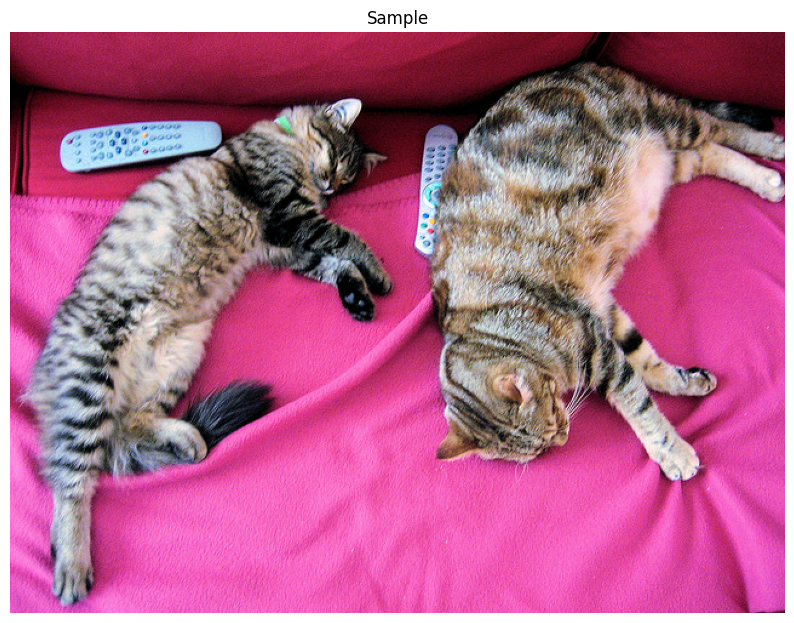

画像サイズ: (640, 480)


In [18]:
# 公式サンプル画像を使用
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"

def load_image_from_url(url):
    """URLから画像を読み込む"""
    response = requests.get(url, stream=True)
    image = Image.open(response.raw).convert("RGB")
    return image

# 画像を読み込み
image = load_image_from_url(image_url)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title("Sample")
plt.axis('off')
plt.show()

print(f"画像サイズ: {image.size}")

In [19]:
# 検出実行！
# テキストプロンプトで検出したいオブジェクトを指定
# 重要: 各オブジェクトは小文字で、ピリオドで終わる必要があります

text_prompt = "a cat. a remote control."

print(f"検出対象: {text_prompt}")
print("検出中...")

boxes, labels, scores = detect_objects(
    image,
    text_prompt,
    box_threshold=0.35,
    text_threshold=0.25
)

print(f"\n検出結果: {len(boxes)}個のオブジェクトを検出")
for i, (label, score) in enumerate(zip(labels, scores)):
    print(f"  {i+1}. {label}: {score:.3f}")

検出対象: a cat. a remote control.
検出中...

検出結果: 3個のオブジェクトを検出
  1. a cat: 0.479
  2. a cat: 0.438
  3. a remote control: 0.476


In [20]:
# 結果を可視化
visualize_detections(image, boxes, labels, scores, threshold=0.3)

Output hidden; open in https://colab.research.google.com to view.

## 様々な画像とプロンプトで実験

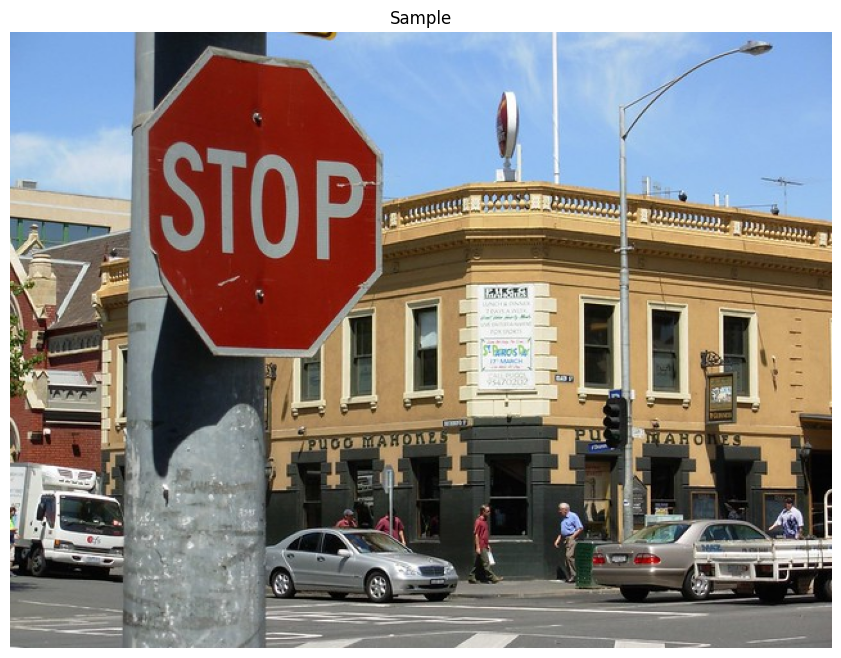

In [21]:
# 別のサンプル画像（街並み）
street_url = "https://farm1.staticflickr.com/102/383362701_0846091527_z.jpg"
street_image = load_image_from_url(street_url)

plt.figure(figsize=(12, 8))
plt.imshow(street_image)
plt.title("Sample")
plt.axis('off')
plt.show()

In [22]:
# 様々なオブジェクトを検出
text_prompt = "a person. a car. a bus. a traffic light."

boxes, labels, scores = detect_objects(street_image, text_prompt, box_threshold=0.3)

print(f"検出対象: {text_prompt}")
print(f"検出数: {len(boxes)}")
for i, (label, score) in enumerate(zip(labels, scores)):
    print(f"  {i+1}. {label}: {score:.3f}")

visualize_detections(street_image, boxes, labels, scores)

Output hidden; open in https://colab.research.google.com to view.

検出対象: food. plate. fork. knife. table.
検出数: 10


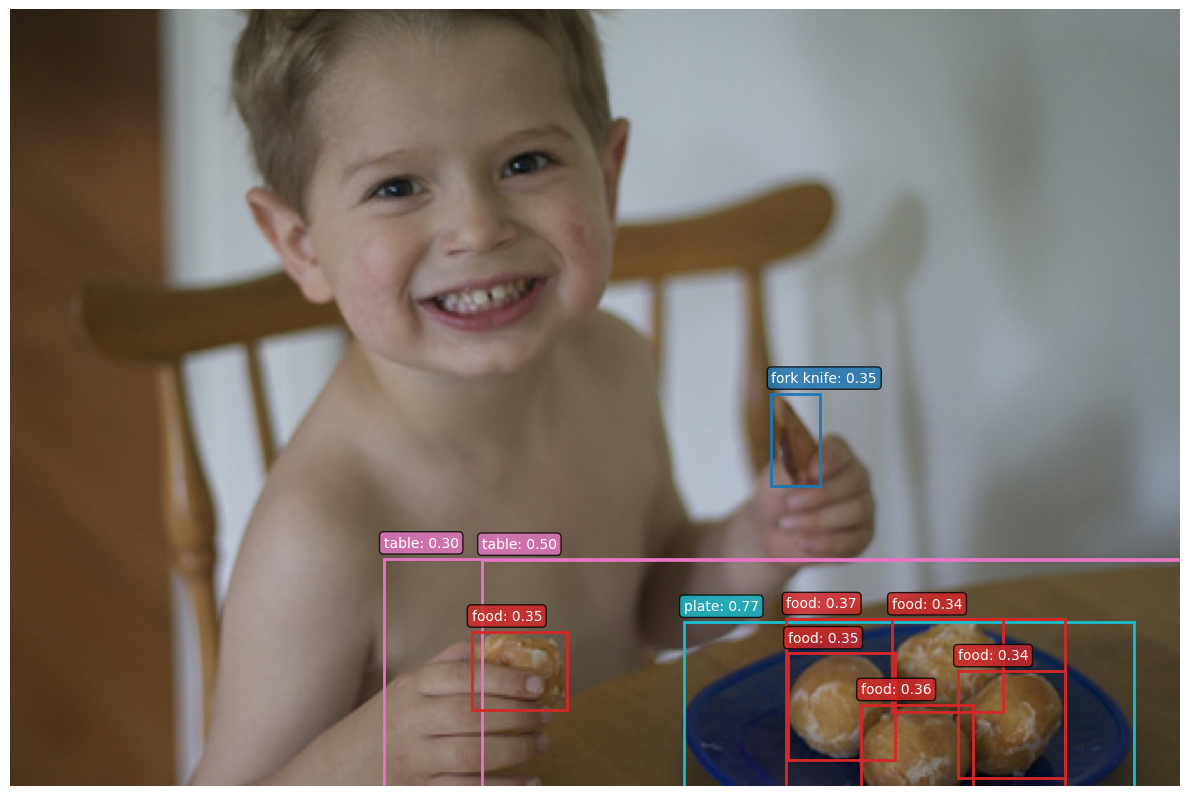

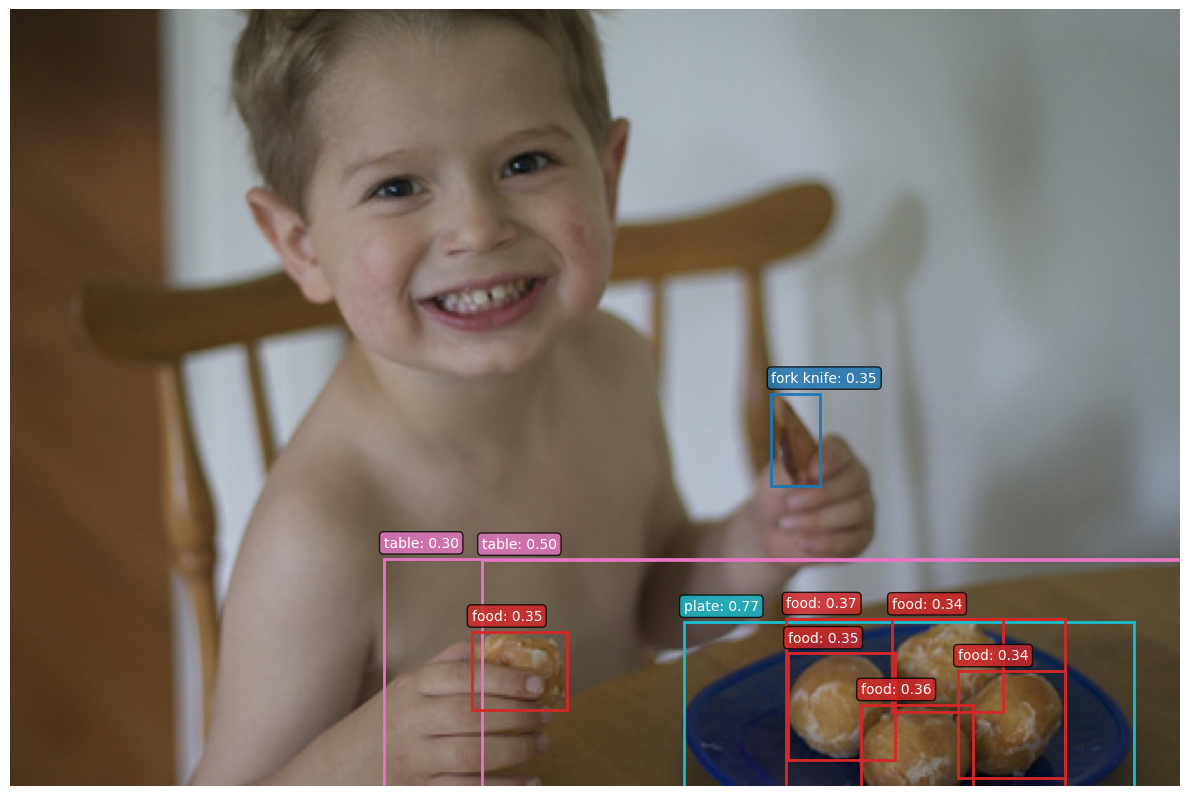

In [23]:
# 食べ物の画像
food_url = "http://images.cocodataset.org/val2017/000000099810.jpg"
food_image = load_image_from_url(food_url)

text_prompt = "food. plate. fork. knife. table."

boxes, labels, scores = detect_objects(food_image, text_prompt, box_threshold=0.25)

print(f"検出対象: {text_prompt}")
print(f"検出数: {len(boxes)}")

visualize_detections(food_image, boxes, labels, scores, threshold=0.25)

## 応用: 検出結果をJSON形式で出力

In [24]:
import json

def export_detections_to_json(image, text_prompt, output_path="detections.json"):
    """検出結果をJSON形式でエクスポート"""
    boxes, labels, scores = detect_objects(image, text_prompt)

    detections = []
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        detection = {
            "id": i,
            "label": label,
            "confidence": float(score),
            "bbox": {
                "x1": float(box[0]),
                "y1": float(box[1]),
                "x2": float(box[2]),
                "y2": float(box[3]),
                "width": float(box[2] - box[0]),
                "height": float(box[3] - box[1])
            }
        }
        detections.append(detection)

    result = {
        "image_size": {"width": image.size[0], "height": image.size[1]},
        "prompt": text_prompt,
        "num_detections": len(detections),
        "detections": detections
    }

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(result, f, indent=2, ensure_ascii=False)

    print(f"検出結果を {output_path} に保存しました")
    return result

# 使用例
result = export_detections_to_json(image, "a cat. a remote control.")
print(json.dumps(result, indent=2, ensure_ascii=False))

検出結果を detections.json に保存しました
{
  "image_size": {
    "width": 640,
    "height": 480
  },
  "prompt": "a cat. a remote control.",
  "num_detections": 3,
  "detections": [
    {
      "id": 0,
      "label": "a cat",
      "confidence": 0.47852060198783875,
      "bbox": {
        "x1": 344.69793701171875,
        "y1": 23.108325958251953,
        "x2": 637.1820068359375,
        "y2": 374.2745056152344,
        "width": 292.48406982421875,
        "height": 351.1661682128906
      }
    },
    {
      "id": 1,
      "label": "a cat",
      "confidence": 0.43790051341056824,
      "bbox": {
        "x1": 12.269372940063477,
        "y1": 51.91024398803711,
        "x2": 316.8564147949219,
        "y2": 472.433837890625,
        "width": 304.5870361328125,
        "height": 420.5235900878906
      }
    },
    {
      "id": 2,
      "label": "a remote control",
      "confidence": 0.4760935306549072,
      "bbox": {
        "x1": 38.58466339111328,
        "y1": 70.00907897949219,
     

## 自分の画像をアップロードして実験

In [25]:
!wget https://farm4.staticflickr.com/3024/3071527933_198eb6ef3e_z.jpg -O cat-pc.jpg

--2026-01-15 19:43:37--  https://farm4.staticflickr.com/3024/3071527933_198eb6ef3e_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 52.85.103.59, 2600:9000:2918:c400:0:5a51:64c9:c681, 2600:9000:2918:6a00:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|52.85.103.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘cat-pc.jpg’

cat-pc.jpg              [ <=>                ]  64.21K  --.-KB/s    in 0.009s  

2026-01-15 19:43:37 (6.92 MB/s) - ‘cat-pc.jpg’ saved [65756]



何でもよいので画像を指定するとよい
- フォルダーにcat-pc.jpgというファイルを保存してあるので、利用してみるとよい

画像ファイルをアップロードしてください...


Saving cat-pc.jpg to cat-pc (1).jpg


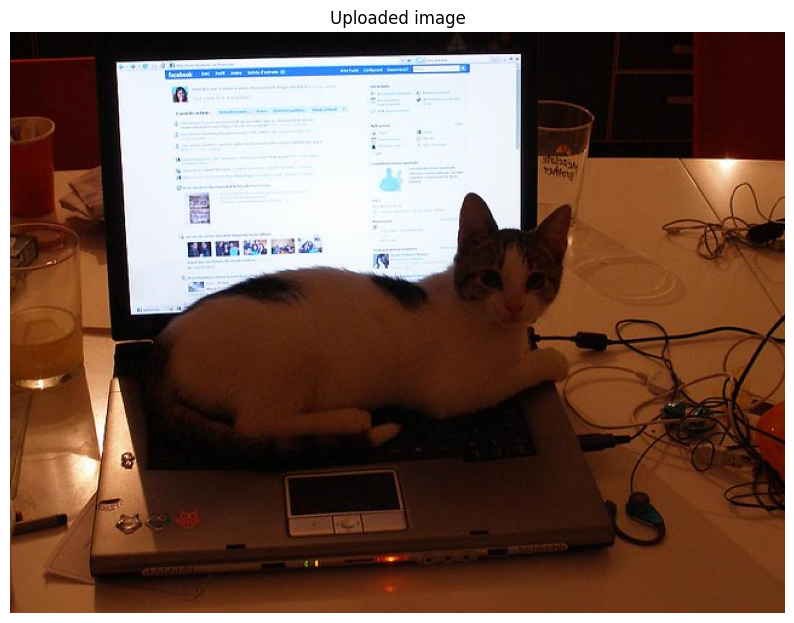

画像サイズ: (640, 480)


In [26]:
from google.colab import files

# ファイルアップロード
print("画像ファイルをアップロードしてください...")
uploaded = files.upload()

if uploaded:
    # アップロードされた最初のファイルを使用
    filename = list(uploaded.keys())[0]
    user_image = Image.open(filename).convert("RGB")

    plt.figure(figsize=(10, 8))
    plt.imshow(user_image)
    plt.title("Uploaded image")
    plt.axis('off')
    plt.show()

    print(f"画像サイズ: {user_image.size}")

検出対象: acat, a pc, a person. a face. a hand. an object.
検出数: 3
  1. a face: 0.415
  2. acat: 0.335
  3. pc: 0.386


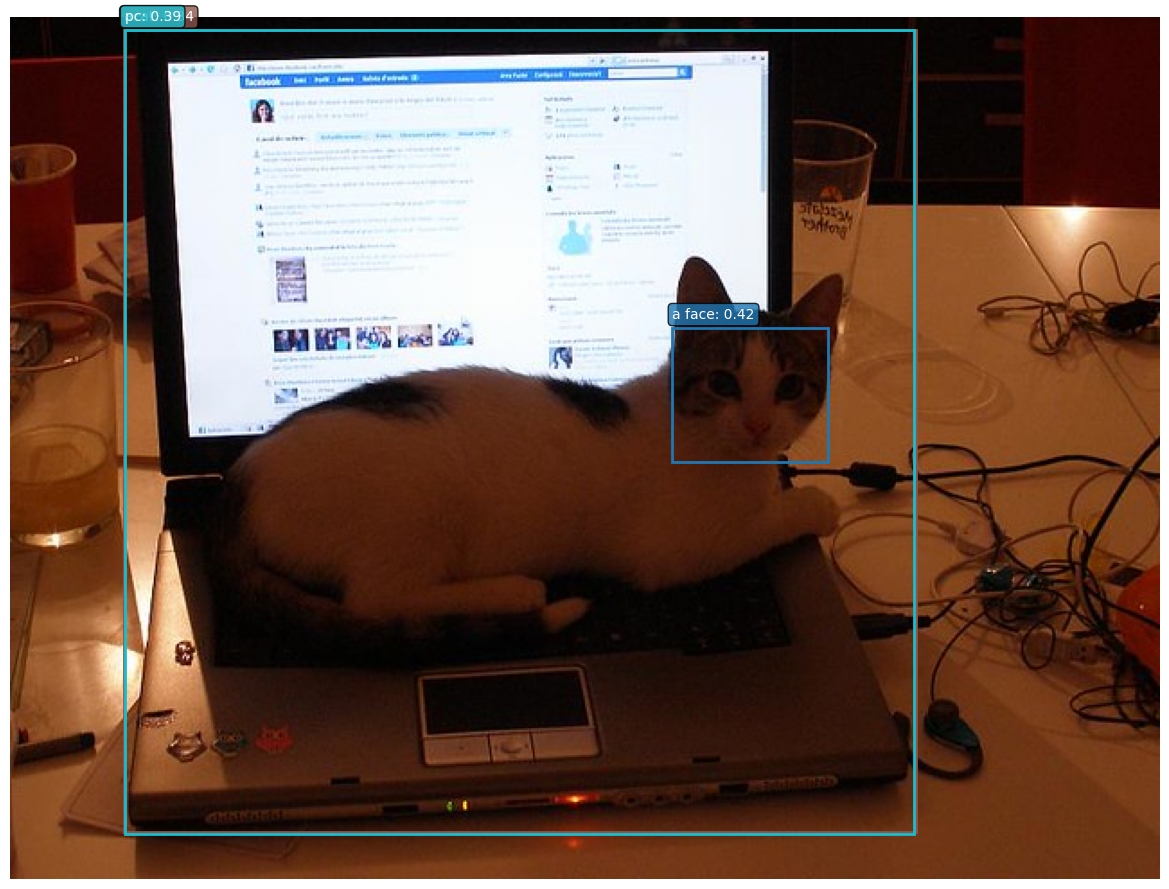

In [27]:
# アップロードした画像で検出を実行
# 検出したいオブジェクトをここに入力してください（小文字 + ピリオド）
text_prompt = "acat, a pc, a person. a face. a hand. an object."  # お好みで変更

if 'user_image' in dir():
    boxes, labels, scores = detect_objects(user_image, text_prompt, box_threshold=0.3)

    print(f"検出対象: {text_prompt}")
    print(f"検出数: {len(boxes)}")
    for i, (label, score) in enumerate(zip(labels, scores)):
        print(f"  {i+1}. {label}: {score:.3f}")

    visualize_detections(user_image, boxes, labels, scores)
else:
    print("先に画像をアップロードしてください。")

## インタラクティブな検出（Gradioを使用）

In [28]:
!pip install -q gradio

「ランタイム」で「セッションの再起動」を実行してから次のセルを実行させるひつようがあるかもしれません

In [29]:
import gradio as gr
from io import BytesIO

def fig_to_array(fig):
    """MatplotlibのfigureをNumPy配列に変換（互換性対応）"""
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    result_image = np.array(Image.open(buf))
    buf.close()
    return result_image

def gradio_detect(image, text_prompt, box_threshold):
    """Gradio用の検出関数"""
    if image is None:
        return None, "画像をアップロードしてください"

    # PIL Imageに変換
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image).convert("RGB")

    # 検出実行
    boxes, labels, scores = detect_objects(
        image, text_prompt,
        box_threshold=box_threshold
    )

    # 結果を描画
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    unique_labels = list(set(labels)) if len(labels) > 0 else []
    colors = plt.cm.tab10(np.linspace(0, 1, max(len(unique_labels), 1)))
    label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        color = label_to_color.get(label, colors[0])
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=3, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{label}: {score:.2f}",
                fontsize=12, color='white',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.8))

    ax.axis('off')
    plt.tight_layout()

    # Figure to numpy array（互換性のある方法）
    result_image = fig_to_array(fig)
    plt.close(fig)

    # 検出結果テキスト
    if len(boxes) == 0:
        result_text = "検出されたオブジェクトはありません。\n\n閾値を下げるか、プロンプトを変更してみてください。"
    else:
        result_text = f"検出数: {len(boxes)}\n\n"
        for i, (label, score) in enumerate(zip(labels, scores)):
            result_text += f"{i+1}. {label}: {score:.3f}\n"

    return result_image, result_text

# Gradioインターフェース作成
demo = gr.Interface(
    fn=gradio_detect,
    inputs=[
        gr.Image(label="入力画像"),
        gr.Textbox(
            label="検出対象（小文字 + ピリオドで区切る）",
            value="a person. a car. a dog. a cat.",
            placeholder="例: a cat. a dog. a bird."
        ),
        gr.Slider(0.1, 0.9, value=0.35, label="Box Threshold（検出感度）"),
    ],
    outputs=[
        gr.Image(label="検出結果"),
        gr.Textbox(label="検出詳細")
    ],
    title="Grounding DINO - オープンボキャブラリー物体検出",
    description="""テキストプロンプトで任意のオブジェクトを検出します。

**重要**: 検出したいオブジェクトは「小文字」で、「ピリオド」で終わる必要があります。
例: "a cat. a dog. a person."
""",
    examples=[
        [None, "a cat. a remote control.", 0.35],
        [None, "a person. a face. a hand.", 0.3],
        [None, "a car. a building. a tree.", 0.35],
    ]
)

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3e77d824273c563be7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3e77d824273c563be7.gradio.live


# 課題3

## 課題3-1

**異なるプロンプトの実験**: 同じ画像に対して、より具体的/抽象的なプロンプトを試してみよう

## 課題3-2

**閾値の調整**: `box_threshold`や`text_threshold`を変えて、精度と再現率のトレードオフを観察しよう

## 課題3-3

**SAMとの組み合わせ**: Grounding DINOの検出結果をSegment Anything Model (SAM)に渡して、セグメンテーションを行いなさい

## 課題3-4

**独自データセットでの評価**: 自分で用意した画像で検出性能を評価しなさい
